In [ ]:
# Install necessary libraries
%pip install networkx jupyter matplotlib numpy pandas openpyxl basemap

In [158]:
# Import libraries

import networkx as nx
import numpy as np
import pandas as pd
import time
import os
import openpyxl
from mpl_toolkits.basemap import Basemap as Basemap
import matplotlib.pyplot as plt
import re
import math


In [159]:
folder_path = "test_topologies"
real_top = [file for file in os.listdir(folder_path) if file.endswith(".xlsx")]
df_nodes = []
df_edges = []

def sort_by_number(file_name):
    match = re.match(r'^(\d+)', file_name)
    if match:
        return int(match.group(1))
    else:
        return float('inf')
    
real_top = sorted(real_top, key=sort_by_number)
print(real_top)

for file in real_top:
    file_path = os.path.join(folder_path, file)
    df_1 = pd.read_excel(file_path)
    df_2 = pd.read_excel(file_path, sheet_name=1)  # Read the second sheet (page) of the .xlsx file
    df_nodes.append(df_1)
    df_edges.append(df_2)

# Now have 2 list of dataframes, one is the nodes and the other is the edges


['0_SANET.xlsx', '1_LAYER42.xlsx', '2_BEYONDTHENETWORK.xlsx', '3_NSFNET13.xlsx']


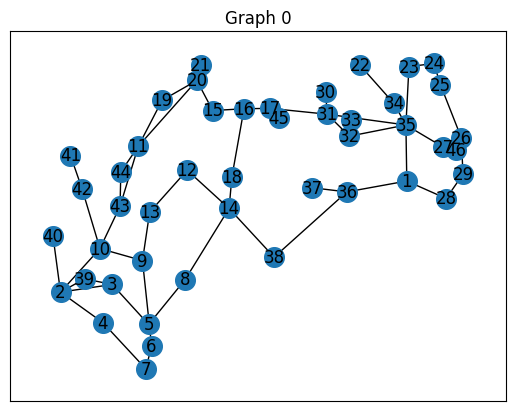

{'G0': <networkx.classes.graph.Graph object at 0x17c7cead0>, 'G0_pos': {1: (22377932.578325644, 65766851.31553012), 2: (21917544.53436922, 65672070.59146247), 3: (21986235.901844747, 65678631.69217774), 4: (21973808.751575205, 65646132.64718034), 5: (22034725.60694999, 65644528.84233915), 6: (22038636.49747089, 65626263.363791), 7: (22031020.971801393, 65606605.26879266), 8: (22083311.69577226, 65682847.61911202), 9: (22026532.523983967, 65698988.48708881), 10: (21969986.661280904, 65709238.33827331), 11: (22020893.520563345, 65796403.851629525), 12: (22085914.178446427, 65776059.79114592), 13: (22036093.070394453, 65740299.41389297), 14: (22141647.484605655, 65743461.44203615), 15: (22119906.60718808, 65826938.46293776), 16: (22161518.375583418, 65828479.758600205), 17: (22195918.533690095, 65828820.43761046), 18: (22145413.321413055, 65770418.6403718), 19: (22052607.343941152, 65835673.5268864), 20: (22098793.024534293, 65852603.501234494), 21: (22104040.81102872, 65865629.69610308),

In [160]:
def create_graph(df_nodes, df_edges):
    # Initialize the Basemap
    map = Basemap(
        projection='merc',
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

    # Extract node positions
    lon = df_nodes['Longitude'].values
    lat = df_nodes['Latitude'].values
    node_id = df_nodes["Node_ID"].values

    # Create position dictionary
    mx, my = map(lon, lat)
    pos = {node_id[i]: (mx[i], my[i]) for i in range(len(node_id))}

    # Extract edges with weights
    src = df_edges["Source"].values
    dest = df_edges["Destination"].values
    weight = df_edges["Computed Length (km)"].values
    edges = [(src[i], dest[i], weight[i]) for i in range(len(weight))]

    # Create and populate the graph
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    return G, pos

def plot_graph(G, pos, title="Graph"):
    nx.draw_networkx(G, pos=pos, node_size=200)
    plt.title(title)
    plt.show()

# Graphs dictionary stores the graph as ab objects and the positions of the nodes
graphs = {}
for i in range(len(real_top)):  # Assuming you have 100 datasets
    nodes = df_nodes[i]
    edges = df_edges[i]
    G, pos = create_graph(nodes, edges)
    graphs[f"G{i}"] = G
    graphs[f"G{i}_pos"] = pos

plot_graph(graphs["G0"], graphs["G0_pos"], "Graph 0")
print(graphs)


In [161]:
# Static methods for all vector operations used such as calculating euclidean distance, dot product, etc.
class VectorOperations:
    def __init__(self):
        pass

    @staticmethod
    def dot(v, w):  # Dot product of two vectors
        x, y = v
        X, Y = w
        return x * X + y * Y

    @staticmethod
    def length(v):  # Length of a vector (magnitude)
        x, y = v
        return (x * x + y * y) ** 0.5

    @staticmethod
    def vector(b, e):  # Subtraction of two vectors
        x, y = b
        X, Y = e
        return (X - x, Y - y)

    @staticmethod
    def unit(v):  # Normalize a vector
        x, y = v
        mag = VectorOperations.length(v)
        return (x / mag, y / mag)

    @staticmethod
    def distance(p0, p1):  # Distance between two points
        return VectorOperations.length(VectorOperations.vector(p0, p1))

    @staticmethod
    def scale(v, sc):  # Scale a vector by a scalar
        x, y = v
        return (x * sc, y * sc)

    @staticmethod
    def add(v, w):  # Add two vectors
        x, y = v
        X, Y = w
        return (x + X, y + Y)

    @staticmethod
    def pnt2line(pnt, start, end):  # Distance from point to line segment
        line_vec = VectorOperations.vector(start, end)
        pnt_vec = VectorOperations.vector(start, pnt)
        line_len = VectorOperations.length(line_vec)
        line_unitvec = VectorOperations.unit(line_vec)
        pnt_vec_scaled = VectorOperations.scale(pnt_vec, 1.0 / line_len)
        t = VectorOperations.dot(line_unitvec, pnt_vec_scaled)
        if t < 0.0:
            t = 0.0
        elif t > 1.0:
            t = 1.0
        nearest = VectorOperations.scale(line_vec, t)
        dist = VectorOperations.distance(nearest, pnt_vec)
        nearest = VectorOperations.add(nearest, start)
        return dist

    @staticmethod
    def dist_euclidean(p1, p2, pos):  # Euclidean distance between two points
        x1, y1 = pos[p1]
        x2, y2 = pos[p2]
        return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5  # Calculate straight-line distance

    @staticmethod
    def vertical_distance(pnt, start, end):
        line_vec = VectorOperations.vector(start, end)
        pnt_vec = VectorOperations.vector(start, pnt)
        line_len = VectorOperations.length(line_vec)
        my_ans = abs(line_vec[0] * pnt_vec[1] - line_vec[1] * pnt_vec[0]) / line_len
        return my_ans


In [172]:
# Note these are called backtracking but are the same as with the weighted graphs.

# The next point is selected based on the shortest vertical distance to the starting point
def Human_gaze_algorithm_backtracking(Graph, start_node, end_node, pos):
    current_node = start_node
    visited_nodes = [start_node]
    dead_nodes = []
    while current_node != end_node:
        neighbors = list(Graph.neighbors(current_node))
        # neighbors are the neighbors of the current node
        for i in visited_nodes:
            if i in neighbors:
                neighbors.remove(i)
        for i in dead_nodes:
            if i in neighbors:
                neighbors.remove(i)
        # Ensure neighbors do not contain dead nodes and visited nodes
        # Remove visited nodes and dead nodes from neighbors
        
        if len(neighbors) == 0:
            visited_nodes.remove(current_node)
            dead_nodes.append(current_node)
        # If the current node has no neighbors, remove it from visited nodes and add it to dead nodes
            while len(neighbors) == 0:                                                  
                # Change the current node to the last one in visited nodes
                current_node = visited_nodes[-1]
                neighbors = list(Graph.neighbors(current_node))
            
                # is this still necessary if we have dead_nodes conditional?
                for i in visited_nodes:
                    if i in neighbors:
                        neighbors.remove(i)
                for i in dead_nodes:
                    if i in neighbors:
                        neighbors.remove(i)
                # Ensure neighbors do not contain dead nodes and visited nodes
                visited_nodes.remove(current_node) 
               
            visited_nodes.append(current_node) 
            
        options = {}
        
        for i in neighbors:
                options[i] = VectorOperations.pnt2line(pnt=pos[i], start=pos[start_node], end=pos[end_node])  # Distance from point to (start-end) line segment
        current_node = min(options, key=options.get) # Find the node with the shortest distance (key)
        visited_nodes.append(current_node)  
               
    return visited_nodes # Return visited nodes

# Select the next point based on the shortest vertical distance from the current point to the end point
def Human_gaze_algorithm_2_backtracking(Graph, start_node, end_node, pos):
    current_node = start_node
    visited_nodes = [start_node]
    dead_nodes = [] # a node might be added multiple times, but it may not be a problem as before
    while current_node != end_node:
        neighbors = list(Graph.neighbors(current_node))
        for i in visited_nodes:
            if i in neighbors:
                neighbors.remove(i)
        for i in dead_nodes:
            if i in neighbors:
                neighbors.remove(i)
        
        if len(neighbors) == 0:
            visited_nodes.remove(current_node)
            dead_nodes.append(current_node)
            
            while len(neighbors) == 0:                                                  
                current_node = visited_nodes[-1]
                neighbors = list(Graph.neighbors(current_node))
                # is this still necessary if we have dead_nodes conditional?
                for i in visited_nodes:
                    if i in neighbors:
                        neighbors.remove(i)
                for i in dead_nodes:
                    if i in neighbors:
                        neighbors.remove(i)
                visited_nodes.remove(current_node) # instead of adding it again to visited nodes, we remove it
                
            visited_nodes.append(current_node) 
            
        options = {} 
        
        for i in neighbors:
                options[i] = VectorOperations.pnt2line(pos[i], pos[current_node], pos[end_node])  # Distance from point to (current-end) line segment
        current_node = min(options, key=options.get)
        visited_nodes.append(current_node)  
               
    return visited_nodes

# Select the next point based on the shortest (vertical distance from the current point to the end point + direct line distance from the current point to the end point)
def Human_gaze_algorithm_3_backtracking(Graph, start_node, end_node, pos):
    current_node = start_node
    visited_nodes = [start_node]
    dead_nodes = [] # a node might be added multiple times, but it may not be a problem as before
    while current_node != end_node:
        neighbors = list(Graph.neighbors(current_node))
        for i in visited_nodes:
            if i in neighbors:
                neighbors.remove(i)
        for i in dead_nodes:
            if i in neighbors:
                neighbors.remove(i)
        
        if len(neighbors) == 0:
            visited_nodes.remove(current_node)
            dead_nodes.append(current_node)
            
            while len(neighbors) == 0:                                                  
                current_node = visited_nodes[-1]
                neighbors = list(Graph.neighbors(current_node))
                # is this still necessary if we have dead_nodes conditional?
                for i in visited_nodes:
                    if i in neighbors:
                        neighbors.remove(i)
                for i in dead_nodes:
                    if i in neighbors:
                        neighbors.remove(i)
                visited_nodes.remove(current_node) # instead of adding it again to visited nodes, we remove it
                
            visited_nodes.append(current_node) 
            
        options = {} 
        
        for i in neighbors:
                options[i] = VectorOperations.pnt2line(pos[i], pos[current_node], pos[end_node]) # Distance from (current-end) line segment
                options[i] += VectorOperations.dist_euclidean(i, end_node, pos)  # Distance from point to end
        current_node = min(options, key=options.get) 
        visited_nodes.append(current_node)  
               
    return visited_nodes

# New HG4 Algorithm from original code
# New HG4 Algorithm, considers the next 2 
def Human_gaze_algorithm_4_backtracking(Graph, start_node, end_node, pos, visit_list=None):
    current_node = start_node
    visited_nodes = [start_node]
    if visit_list is not None:
        for i in visit_list:
            if i not in visited_nodes:
                visited_nodes.append(i)
    dead_nodes = []
    while current_node != end_node:
        neighbors = list(Graph.neighbors(current_node))
        for i in visited_nodes:
            if i in neighbors:
                neighbors.remove(i)
        for i in dead_nodes:
            if i in neighbors:
                neighbors.remove(i)

        if len(neighbors) == 0:
            visited_nodes.remove(current_node)
            dead_nodes.append(current_node)

            while len(neighbors) == 0:
                current_node = visited_nodes[-1]
                neighbors = list(Graph.neighbors(current_node))
                # is this still necessary if we have dead_nodes conditional
                for i in visited_nodes:
                    if i in neighbors:
                        neighbors.remove(i)
                for i in dead_nodes:
                    if i in neighbors:
                        neighbors.remove(i)
                visited_nodes.remove(
                    current_node)  # instead of adding it again to visited nodes we want to take it away

            visited_nodes.append(current_node)

        options = {}
        for i in neighbors:
            options[i] = VectorOperations.vertical_distance(pos[i], pos[start_node], pos[end_node])
            temp_neighbors = list(Graph.neighbors(i))
            temp_options = {}
            for j in visited_nodes:
                if j in temp_neighbors:
                    temp_neighbors.remove(j)
            for j in dead_nodes:
                if j in neighbors:
                    neighbors.remove(j)
            for j in temp_neighbors:
                if j == end_node:
                    temp_options[j] = 0
                else:
                    temp_options[j] = VectorOperations.vertical_distance(pos[j], pos[start_node], pos[end_node])
            if len(temp_options) == 0:
                break
            temp_node = min(temp_options, key=temp_options.get)
            options[i] += temp_options[temp_node]

        current_node = min(options, key=options.get)
        visited_nodes.append(current_node)

    return visited_nodes

## Cost266 real world network
### From original code
#### Extracted from SNDLib

### Storing all pairs in our lists for the algorithms

In [167]:
# for dijkstra we might need to specify some argument for it to take weightings into account
# Obtain the shortest path between all points
# DG_1 to DG_26 is repeated in original code


dg_paths = {}
hg1_paths = {}
hg2_paths = {}
hg3_paths = {}
hg4_paths = {}
astar_paths = {}

# This code calculates the path using all the algorithms across every single point of the graphs, the grahs tested are the 105 real topologies
for i in range(len(real_top)):
    dg_list = []
    hg1_list = []
    hg2_list = []
    hg3_list = []
    hg4_list = []
    a_star_list = []
    for j in graphs[f"G{i}"].nodes:
        for k in graphs[f"G{i}"].nodes:
            dg_list.append(nx.dijkstra_path(graphs[f"G{i}"], j, k, weight="weight"))
            hg1_list.append(Human_gaze_algorithm_backtracking(graphs[f"G{i}"], j, k, graphs[f"G{i}_pos"]))
            hg2_list.append(Human_gaze_algorithm_2_backtracking(graphs[f"G{i}"], j, k, graphs[f"G{i}_pos"]))
            hg3_list.append(Human_gaze_algorithm_3_backtracking(graphs[f"G{i}"], j, k, graphs[f"G{i}_pos"]))
            hg4_list.append(Human_gaze_algorithm_4_backtracking(graphs[f"G{i}"], j, k, graphs[f"G{i}_pos"]))
            a_star_list.append(nx.astar_path(graphs[f"G{i}"], j, k, heuristic=lambda x, y: VectorOperations.dist_euclidean(x, y, graphs[f"G{i}_pos"]), weight="weight"))
    
    dg_paths[f"DG_{i}"] = dg_list
    hg1_paths[f"HG1_{i}"] = hg1_list
    hg2_paths[f"HG2_{i}"] = hg2_list
    hg3_paths[f"HG3_{i}"] = hg3_list
    hg4_paths[f"HG4_{i}"] = hg4_list
    astar_paths[f"A_{i}"] = a_star_list



### Error percentage with respect to Dijkstra

In [168]:
#   L1 and L2 are lists of shortest paths for all points, that is, DG_1 and A_1
#   L1 should be the benchmark, which is A* or Dijkstra

def compare_path(L1, L2): #inputs are the list of list(paths) for all node pairs for dijkstra and HG, same size lists
    different_path = []
    n = 0
    if L1 == L2:
        return "Equal"
    else:
        for i in range(len(L1)): #L1 and L2 should be the same length
            if len(L1[i]) < len(L2[i]):
                n += 1
                different_path.append([L1[i], L2[i]])
        #return [different_path, n, len(L1), n/len(L1)*100] 
        return different_path
    
#   Does not take into account if the weight of the path is longer or shorter, just hops here, so not good for the real world networks

# Calculates only the number of hops in the path, path length is ignored, returns the percentage difference in the number of hops of HG and A*    
def HG_error(L1, L2):  # The error rate of HG, where L1 is the control group and L2 is the HG algorithm's experimental group
    n = 0
    if L1 == L2:
        return "Equal"
    else:
        for i in range(len(L1)): #L1 and L2 should be the same length
            if len(L1[i]) < len(L2[i]):
                n += 1
                
        return n/len(L1)*100

In [170]:
# This code caculates the hop error rate of the HG algorithms with respect to the Dijkstra algorithm
# Percentage increase of hops are identified
for i in range(len(real_top)):
    hg1_error = HG_error(dg_paths[f"DG_{i}"], hg1_paths[f"HG1_{i}"])
    hg2_error = HG_error(dg_paths[f"DG_{i}"], hg2_paths[f"HG2_{i}"])
    hg3_error = HG_error(dg_paths[f"DG_{i}"], hg3_paths[f"HG3_{i}"])
    hg4_error = HG_error(dg_paths[f"DG_{i}"], hg4_paths[f"HG4_{i}"])
    a_error = HG_error(dg_paths[f"DG_{i}"], astar_paths[f"A_{i}"])

# As network connectivity increases the error with respect to Dijkstra decreases


### When there is an additional heuristic, it is usually best to always take the geodesic path from the start to the end.

### Look at graphs with latitude and longitude inverted to see how this might affect performance, such as in version 3.

### Find the total weight of the paths for comparison with Dijkstra's algorithm.

In [ ]:
# Comparing the weight of the paths

def path_weight_sum(path, Graph): #path is the list of nodes for one node pair, e.g. DG_list[0][1]
    sum_weight = 0
    for i in range(1,len(path)):
        sum_weight += Graph.edges[path[i-1], path[i]]['weight']
    return sum_weight #returns total weight of path for one node pair

def all_path_weight_sum_average(path, Graph): 
    k = 0
    for i in range(len(path)):
        k += path_weight_sum(path[i], Graph)
    average = (k/len(path))
    return average # returns average weight of all summed weight of each node pair

def all_path_weight_sum_compare(path1, path2, Graph):
    
    average1 = all_path_weight_sum_average(path1, Graph)
    average2 = all_path_weight_sum_average(path2, Graph)
    difference = abs(average1-average2)
    return difference # returns the difference of the average for two graphs with all node pairs

def average_edge_weight(Graph):
    sum_weight = 0
    for i in list(Graph.edges):
        sum_weight += Graph.edges[i]["weight"]
    average_weight = (sum_weight/len(list(Graph.edges)))
    return average_weight

# what is edge weight?
def HG_error_weight(L1, L2, Graph):
    n = 0
    for i in range(len(L1)): #L1 and L2 should be the same length
        if path_weight_sum(L1[i], Graph) < path_weight_sum(L2[i], Graph):
            n += 1
    ## HG is also weight? what does it represent?
    return n/len(L1)*100
        

In [ ]:
"""
Calculates the 

1. average of the path weighs of the graph
2. Compares the average of the path weights (avergae1 - avergae2)
3. Average edge weight of the graph
4. percentage error where he takes the number of graphs that did not match the benchmark path weight

"""


class GraphAnalysis:
    
    @staticmethod
    def  path_weight_sum(path, graph): 
        """Calculate the total weight of a given path."""
        sum_weight = 0
        for i in range(1, len(path)):
            sum_weight += graph.edges[path[i-1], path[i]]['weight']
        return sum_weight

    @staticmethod
    def all_path_weight_sum_average(paths, graph): 
        """Calculate the average weight of all paths."""
        total_weight = sum(GraphAnalysis.path_weight_sum(path, graph) for path in paths)
        average = total_weight / len(paths) if paths else 0
        return average

    @staticmethod
    def all_path_weight_sum_compare(paths1, paths2, graph):
        """Compare the average weights of two sets of paths."""
        average1 = GraphAnalysis.all_path_weight_sum_average(paths1, graph)
        average2 = GraphAnalysis.all_path_weight_sum_average(paths2, graph)
        difference = abs(average1 - average2)
        return difference

    @staticmethod
    def average_edge_weight(graph):
        """Calculate the average weight of edges in the graph."""
        sum_weight = 0
        for i in list(graph.edges):
            sum_weight += graph.edges[i]["weight"]
        average_weight = (sum_weight/len(list(graph.edges)))
        return average_weight

    @staticmethod
    def HG_error_weight(L1, L2, Graph):
        """Calculate the percentage error rate of HG based on number of graphs where the path weight is above the benchmark."""
        n = 0
        for i in range(len(L1)): #L1 and L2 should be the same length
            if GraphAnalysis.path_weight_sum(L1[i], Graph) < GraphAnalysis.path_weight_sum(L2[i], Graph):
                n += 1
        ## HG is also weight? what does it represent?
        return n/len(L1)*100
    
    @staticmethod
    def network_connectivity(graph):
        edges = list(graph.edges())
        nodes = list(graph.nodes())
        return (2*len(edges))/(len(nodes)*(len(nodes)-1))

    

"""
What sort of calcuatiosn do we even need for this? how many pages should the paper be? what number are we most interested in?

Calculations he did (functions used)
1. HG_error_weight
2. all_path_weight_sum_compare
3. all_path_weight_sum_average

He basically calculated and print out the values of all these functions for all graphs and algorithms

"""


# Measure of Network connectivity

In [171]:
# Calculates Edge Density of the graphs
def network_connectivity(Graph):
    edges = list(Graph.edges())
    nodes = list(Graph.nodes())
    return (2*len(edges))/(len(nodes)*(len(nodes)-1))

    
# This prints the network connectivity of the graphs
for i in range(len(real_top)):
    print(network_connectivity(graphs[f"G{i}"]))
    
# These are all very low network connectivity in regards to when we measured hops on random graphs

0.05314009661835749
0.4666666666666667
0.10098522167487685
0.19230769230769232


# Measure Runtime

In [ ]:
def Runtime(path): # for individual paths
    start_time = time.time()
    path
    end_time = time.time()
    return end_time-start_time


def compare_runtime(Graph, Graph_set_DG, Graph_set_HG, algorithm, pos): #always compare HG versions to dijkstra since we don't specify the alg. in the arguments
   
    time_start_HG = time.perf_counter()
    for i in list(Graph.nodes):
        for j in list(Graph.nodes):
            Graph_set_HG.append(algorithm(Graph, i, j, pos))
    time_elapsed_HG = (time.perf_counter() - time_start_HG)
#   memMb_HG=resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024.0/1024.0
    
    time_start_DG = time.perf_counter()
    for i in list(Graph.nodes):
        for j in list(Graph.nodes):
            Graph_set_DG.append(nx.dijkstra_path(Graph, i, j))
    time_elapsed_DG = (time.perf_counter() - time_start_DG)
#   memMb_DG=resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024.0/1024.0

#   return print ("%5.1f secs %5.1f MByte" % (time_elapsed_DG,memMb_DG), "%5.1f secs %5.1f MByte" % (time_elapsed_HG,memMb_HG))
#    return print ("secs" % time_elapsed_DG, " secs" % time_elapsed_HG)
    return print ("%5.3f secs" % time_elapsed_DG, "%5.3f secs" % time_elapsed_HG)


def compare_runtime_2(path1, path2): # comparind individual paths
    start_time_1 = time.time()
    path1
    end_time_1 = time.time()
    
    start_time_2 = time.time()
    path2
    end_time_2 = time.time()
    return (end_time_1-start_time_1,end_time_2-start_time_2)


"""
1. After that he calculates uses compare_runtime function for all the graphs and algorithms
2. Then he uses compare_runtime_2 for certain paths and algorithm

# NOTE: the graphs are arranged in increasing order of network connectivity, for other measures this is usefull to
# show evolution of a parameter as network connectivity inrcreases, but run time depends on how big the network,
# and not as much the ratio of nodes to links

"""

# Average length of path
### Might not be relevant here due to the weightings

In [ ]:
def average_len(lst):
    lengths = [len(i) for i in lst]
    return 0 if len(lengths) == 0 else (float(sum(lengths)) / len(lengths))



In [ ]:
for i in HG1_list:
    print(average_len(i))

# this is done for HG1_list to HG4 list and DG_list

## Next section is for plotting

In [ ]:
import matplotlib.pyplot as plt

"""
He then creates the following variables:

1. network conectivity
2. path_error for HG1 to HG4 and DG, A*
3. weight error for HG1 to HG4, DG, A*
4. avergae len for HG1 to HG4 and DG and A*
5. weight paths for HG1 to HG4 and DG and A*
6. weight paths flattened(normalised) for HG1 to HG4 and DG and A*, which is the weight paths divided by the average weight of a single hop (average_edge_weight)

"""

# 26 elements in this list representing the 26 diff graphs tested
network_connectivity = [0.22727272727272727, 
0.20952380952380953, 
0.012888198757763975, 
0.08558558558558559, 
1.0, 
0.8545454545454545, 
0.7636363636363637, 
0.15, 
0.15584415584415584, 
0.07183673469387755, 
0.11605937921727395, 
0.13445378151260504, 
0.12923076923076923, 
0.08502024291497975, 
0.4083333333333333, 
0.10846560846560846, 
0.19117647058823528, 
0.23076923076923078, 
0.1452991452991453, 
0.6181818181818182, 
0.11794871794871795, 
0.2727272727272727, 
0.1452991452991453, 
0.18478260869565216, 
0.051923076923076926, 
0.055904961565338925]
# this is done for network_connectivity_1 to network_connectivity_5

path_error_HG1 = [13.88888888888889, 
13.777777777777779, 
25.654874426140967, 
35.42731921110299, 
0.0, 
1.6528925619834711, 
4.132231404958678, 
54.08, 
35.12396694214876, 
44.48, 
43.852728468113085, 
38.12244897959184, 
33.43195266272189, 
41.68310322156476, 
10.15625, 
24.872448979591837, 
22.837370242214533, 
19.387755102040817, 
25.377229080932786, 
0.8264462809917356, 
61.375, 
20.13888888888889, 
27.983539094650205, 
44.44444444444444, 
68.21301775147928, 
71.50205761316872]
# This is done for path_error_HG1 to path_error_HG4


weight_error_HG1 = [15.972222222222221, 
31.555555555555554, 
27.07457274024922, 
45.58071585098612, 
4.0, 
12.396694214876034, 
23.140495867768596, 
63.519999999999996, 
41.32231404958678, 
61.08, 
72.58382642998028, 
68.40816326530611, 
42.30769230769231, 
47.07429322813938, 
41.40625, 
41.70918367346938, 
26.989619377162633, 
22.448979591836736, 
53.90946502057613, 
0.8264462809917356, 
72.0, 
23.61111111111111, 
55.00685871056241, 
54.34027777777778, 
73.6094674556213, 
75.960219478738]
# This is done for weight_error_HG1 to weight_error_HG4

average_len_HG1 = [3.5833333333333335, 
3.6977777777777776, 
4.761081748389337, 
6.316289262235208, 
1.9, 
2.074380165289256, 
2.165289256198347, 
5.5104, 
4.553719008264463, 
7.4008, 
5.7666009204470745, 
4.675918367346939, 
5.044378698224852, 
6.493754109138725, 
2.7890625, 
5.344387755102041, 
4.418685121107266, 
3.7857142857142856, 
4.802469135802469, 
2.347107438016529, 
7.681875, 
3.4097222222222223, 
4.964334705075446, 
4.348958333333333, 
10.286153846153846, 
10.929355281207133]
# This is done for average_len_HG1 to average_len_HG4 and DG

average_len_DG = [3.375, 
3.488888888888889, 
4.376181474480151, 
4.9912344777209645, 
1.94, 
2.1404958677685952, 
2.1735537190082646, 
3.6432, 
3.5950413223140494, 
5.3512, 
4.438527284681131, 
3.973061224489796, 
4.180473372781065, 
5.0788954635108485, 
2.7734375, 
4.589285714285714, 
3.6782006920415227, 
3.2448979591836733, 
4.174211248285323, 
2.3388429752066116, 
4.2575, 
2.9722222222222223, 
4.314128943758574, 
3.329861111111111, 
5.186508875739645, 
5.041152263374485]


# all path sum weight is important to compare with network connectivity as it depends on the weights
# which can be anything

weight_paths_HG1 = [1338.70680878129, 
15331.610742436596, 
305.24753370905245, 
1204.9750072646768, 
186.17232995884638, 
201.3294989293679, 
7857.7742052037975, 
23999.70644398758, 
1547.249483447218, 
578.4235951703707, 
32060.287890684376, 
2253.6263308902185, 
2510.4985887152843, 
1660.0953368717671, 
6589.375789834789, 
1018.7971332886902, 
245.98781473962984, 
1546.546128361766, 
26800.123698991614, 
183.29986196793382, 
40105.04986276331, 
239.29680401578213, 
24584.92183821096, 
15730.065446171935, 
35141.173320234535, 
42980.62499419267]
# This is done for weight_paths_HG1 to weight_paths_HG4 and weight_paths_HG4


# try dividing weight paths by average weight of a single hop to have better size comparison

# Do other way, for each graph e.g. network connectivity (take x ticks as graphs), print Hg path weight alongside DG

# here i divide the number by the average hop weight so they are closer in range
#weight_paths_HG1_flattend = [14186.474331277424/1251.23 ,3870.2535164565948/391.78 ,542.7020560000005/100.04 ,3691.8952222222247/696.20 ,28.42886048210373/6.48 ]
#weight_paths_HG2_flattend = [14179.31348090975/1251.23 ,3390.2804884630023/391.78 ,431.02597599999996/100.04 ,3510.2480000000014/696.20 ,24.83388604821037/6.48 ]
#weight_paths_HG3_flattend = [9153.607202717323/1251.23 ,2835.5111969209424/391.78 ,386.1101720000008/100.04 ,3249.7039999999997/696.20 ,22.67699780861948/6.48]
#weight_paths_HG34_flattend =[]
#weight_paths_DG_flattend = [7069.538188712105/1251.23 ,2531.6355600553625/391.78 ,368.3345280000004/100.04 ,2962.206666666665/696.20 ,21.311117604090622/6.48 ]

weight_paths_HG1_flattend = [1338.70680878129/589.2362050807661, 
15331.610742436596/6305.6643213281, 
305.24753370905245/49.12849286059849, 
1204.9750072646768/273.9206166153562, 
186.17232995884638/206.85814439871825, 
201.3294989293679/201.28745827032466, 
7857.7742052037975/6540.4617849519755, 
23999.70644398758/5540.277344680144, 
1547.249483447218/656.2983811864766, 
578.4235951703707/111.78150491530495, 
32060.287890684376/6567.3067220302755, 
2253.6263308902185/524.7610747905527, 
2510.4985887152843/623.3589858233048, 
1660.0953368717671/328.262086857534, 
6589.375789834789/3998.1874226858513, 
1018.7971332886902/267.38857896958444, 
245.98781473962984/89.00510854890588, 
1546.546128361766/675.1327252086693, 
26800.123698991614/7135.898675966775, 
183.29986196793382/156.61713249135215, 
40105.04986276331/6378.358711956579, 
239.29680401578213/110.18548990652214, 
24584.92183821096/6322.555693766808, 
15730.065446171935/5526.47365156454, 
35141.173320234535/4205.338341609698, 
42980.62499419267/4961.110074368485]
# This is repeated from weight_paths_HG1_flattend to weight_paths_HG4_flattend and DG 


## Python weight graphs
### All about plotting Network connectivity against path weight/path weight normalised/ path weight on log scale

In [ ]:
# PLOT 1

"""
THIS SECTION EXPLAINS THE PLOTS FOR PLOT 1 . THE PREVIOUS PERSON MADE FOR THE DATA

1. Plot normalised & not normalised weighted paths against network connectivity for all algorithms runned on all graphs
2. Plot path error against network connectivity for all algorithms runned on all graphs
3. PLot of average path length against network connectivity for all algorithms runned on all graphs
4. Plot of weight error against network connectivity for all algorithms runned on all graphs
5. 

"""

In [ ]:




# He plots a graph of the normalized path weight for each graph agaisnt network connectivity for HG1 to HG4 and it is compared with Dijkstra which is also plotted
# weights plath flattened is the normalized path weight, calculated previously

plt.figure(figsize=(70,20))
plt.bar(network_connectivity, weight_paths_HG1_flattend, width=0.001,align='edge', label="Version 1")
plt.bar(network_connectivity_2, weight_paths_DG_flattend, width=0.001,align='edge', label="Dijkstra")
plt.xlabel("Network Connectivity")
plt.ylabel("Path weight normalized")
plt.legend()

In [ ]:
# Network connectivity is tplotted against the log of path distance for HG1 to HG4 and Dijkstra
# alot more plots giing on here as well but makes not much sense at this point

# unflattend with log
plt.figure(figsize=(100,20))
plt.bar(network_connectivity, weight_paths_HG1, width=0.001, align='edge', label="Version 1", log=True)
plt.bar(network_connectivity_2, weight_paths_HG2, width=0.001, align='edge', label="Version 2", log=True)
plt.bar(network_connectivity_3, weight_paths_HG3, width=0.001, align='edge', label="Version 3", log=True)
#plt.bar(network_connectivity_4, weight_paths_HG4, width=0.001, align='edge', label="Version 4", log=True)
plt.bar(network_connectivity_5, weight_paths_DG, width=0.001, align='edge', tick_label=["G1", "G2", "G3", "G4", "G5","G6","G7","G8","G9","G10","G11"
,"G12","G13","G14","G15","G16","G17","G18","G19","G20","G21","G22","G23","G24","G25","G26"], label="Dijkstra", log=True)
plt.xlabel("Network Connectivity")
plt.ylabel("Path distance (log)")
plt.legend()
plt.show()


## Python path length graphs
### All about plotting Network connectivity against path weight/path weight normalised/ path weight on log scale

In [ ]:
# This is plotted of network connectivity against path error
# The plot for network conneciticty agaisnt avergae path length is done for HG1 to HG4 compared to Dijkstra

plt.figure(figsize=(100,20))
plt.bar(network_connectivity, average_len_HG1, width=0.001,align='center', label="Version 1")
plt.bar(network_connectivity_2, average_len_HG2, width=0.001,align='center', label="Version 2")
plt.bar(network_connectivity_3, average_len_HG3, width=0.001,align='center', label="Version 3")
plt.bar(network_connectivity_4, average_len_HG4, width=0.001,align='center', label="Version 4")
plt.bar(network_connectivity_5, average_len_DG, width=0.001,align='center', label="Dijkstra")
plt.xlabel("Network Connectivity")
plt.ylabel("Average path length")
plt.legend()
plt.show()

In [ ]:
# this is what come next 

# Try version three without the geodesic to see if it is good without it
# maybe path error should be using weightings here to determine the percenatge of paths that are longer than dijkstra
# path weight already covers this in a different way by comparing directly to dijkstra 
# instead of using dijkstra as a baseline

plt.figure(figsize=(100,20))
plt.bar(network_connectivity, weight_error_HG1, width=0.001,align='center', label="Version 1")
plt.bar(network_connectivity_2, weight_error_HG2, width=0.001,align='center', label="Version 2")
plt.bar(network_connectivity_3, weight_error_HG3, width=0.001,align='center', label="Version 3")
plt.bar(network_connectivity_4, weight_error_HG4, width=0.001,align='center', label="Version 4")
plt.xlabel("Network Connectivity")
plt.ylabel("Non optimal path distance")
plt.legend()
plt.show()

#Plot 1 Length and % of longer paths, m value vs path length (hops?)

# Plot 2 (according to him)

In [ ]:
# PLOT 2

"""
THIS SECTION EXPLAINS THE PLOTS FOR PLOT 2. THE PREVIOUS PERSON MADE FOR THE DATA

1. all_path_weight_sum_average is calculated for all algorithms and graphs
2. all_path_weight_sum_average_normalised is calculated for all algorithms and graphs


"""

In [ ]:
# Gets the avergae length of a path in the graph and normalise it
def all_path_weight_sum_average_normalised(path, Graph): 
    k = 0
    for i in range(len(path)):
        k += path_weight_sum(path[i], Graph)
    average = (k/len(path))
    return average/average_edge_weight(Graph)

In [ ]:
# This finds the maximum dijkstra path in the graphs
def max_DG(LDG):
    max_DG_value = 0
    for i in range(len(LDG)):
        for j in range(len(LDG[i])):
            if path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i])>max_DG_value:
                max_DG_value = path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i])
            
    return max_DG_value

# Plot 2 with pseudo hops

In [ ]:
"""

plot_2_data (NOT WORKING): Basically calculates the relatvie path lengths for each alogrithm, then splits into 10 differen categories based on the relative path length
Then calculates the average path length for each category for each algorithm
A list of the average path length is outputted for each catoegory for each algorithm

Following are the plots made:

1. average pseudohop percentage agaisnt pseudohops route for each human gaze algorithm
2. extra percentage of distance comapred to dijkstra for each algoritm
3. Average hops with respect to Dijsktra for each algorithm
4. Average % of extra km with respect to Dijkstra for each algorithm
5. 


"""

# Function does not work
def plot_2_data(LDG, LHG1, LHG2, LHG3): 
    # Inputs are the list of all the paths for each algorithm
    # len(DG_list) is 26, not all DG_list[i] are of the same length as they all have a different number of nodes

    DG_pathweight_1 = []
    DG_pathweight_2 = []
    DG_pathweight_3 = []
    DG_pathweight_4 = []
    DG_pathweight_5 = []
    DG_pathweight_6 = []
    DG_pathweight_7 = []
    DG_pathweight_8 = []
    DG_pathweight_9 = []
    DG_pathweight_10 = []
    
    HG1_pathweight_1 = []
    HG1_pathweight_2 = []
    HG1_pathweight_3 = []
    HG1_pathweight_4 = []
    HG1_pathweight_5 = []
    HG1_pathweight_6 = []
    HG1_pathweight_7 = []
    HG1_pathweight_8 = []
    HG1_pathweight_9 = []
    HG1_pathweight_10 = []
    
    HG2_pathweight_1 = []
    HG2_pathweight_2 = []
    HG2_pathweight_3 = []
    HG2_pathweight_4 = []
    HG2_pathweight_5 = []
    HG2_pathweight_6 = []
    HG2_pathweight_7 = []
    HG2_pathweight_8 = []
    HG2_pathweight_9 = []
    HG2_pathweight_10 = []
    
    HG3_pathweight_1 = []
    HG3_pathweight_2 = []
    HG3_pathweight_3 = []
    HG3_pathweight_4 = []
    HG3_pathweight_5 = []
    HG3_pathweight_6 = []
    HG3_pathweight_7 = []
    HG3_pathweight_8 = []
    HG3_pathweight_9 = []
    HG3_pathweight_10 = []
    
    
    #This is to go through all paths found by Dijkstra on all graphs and all node pairs
    for i in range(len(LDG)):
        for j in range(len(LDG[i])):
            
            # Now to look at each paths total weight and divide by the respective graph's average edge weight
            # Then do if statement to split these up into the six groups
            
            #Then for each node pair path found by Dijkstra, we need to get the equivalent node pair path found by each
            # of the HG algorithms. Store these in a list of their own (1 list per algorithm per categorie).
            # Then take the average of the values in the list. Then we can proceed to see by how juch longer they each are
            # to their respective Dijkstra category.
            
            if path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i])<1.5:
                DG_pathweight_1.append(path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG1_pathweight_1.append(path_weight_sum(LHG1[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG2_pathweight_1.append(path_weight_sum(LHG2[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG3_pathweight_1.append(path_weight_sum(LHG3[i][j], graphs[i])/average_edge_weight(graphs[i]))
            
            elif path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i])<2.5:
                DG_pathweight_2.append(path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG1_pathweight_2.append(path_weight_sum(LHG1[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG2_pathweight_2.append(path_weight_sum(LHG2[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG3_pathweight_2.append(path_weight_sum(LHG3[i][j], graphs[i])/average_edge_weight(graphs[i]))
            
            elif path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i])<3.5:
                DG_pathweight_3.append(path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG1_pathweight_3.append(path_weight_sum(LHG1[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG2_pathweight_3.append(path_weight_sum(LHG2[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG3_pathweight_3.append(path_weight_sum(LHG3[i][j], graphs[i])/average_edge_weight(graphs[i]))
            
            elif path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i])<4.5:
                DG_pathweight_4.append(path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG1_pathweight_4.append(path_weight_sum(LHG1[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG2_pathweight_4.append(path_weight_sum(LHG2[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG3_pathweight_4.append(path_weight_sum(LHG3[i][j], graphs[i])/average_edge_weight(graphs[i]))
                
            elif path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i])<5.5:
                DG_pathweight_5.append(path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG1_pathweight_5.append(path_weight_sum(LHG1[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG2_pathweight_5.append(path_weight_sum(LHG2[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG3_pathweight_5.append(path_weight_sum(LHG3[i][j], graphs[i])/average_edge_weight(graphs[i]))
                
            elif path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i])<6.5:
                DG_pathweight_6.append(path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG1_pathweight_6.append(path_weight_sum(LHG1[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG2_pathweight_6.append(path_weight_sum(LHG2[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG3_pathweight_6.append(path_weight_sum(LHG3[i][j], graphs[i])/average_edge_weight(graphs[i]))
                
            elif path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i])<7.5:
                DG_pathweight_7.append(path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG1_pathweight_7.append(path_weight_sum(LHG1[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG2_pathweight_7.append(path_weight_sum(LHG2[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG3_pathweight_7.append(path_weight_sum(LHG3[i][j], graphs[i])/average_edge_weight(graphs[i]))
                
            elif path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i])<8.5:
                DG_pathweight_8.append(path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG1_pathweight_8.append(path_weight_sum(LHG1[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG2_pathweight_8.append(path_weight_sum(LHG2[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG3_pathweight_8.append(path_weight_sum(LHG3[i][j], graphs[i])/average_edge_weight(graphs[i]))
                
            elif path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i])<9.5:
                DG_pathweight_9.append(path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG1_pathweight_9.append(path_weight_sum(LHG1[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG2_pathweight_9.append(path_weight_sum(LHG2[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG3_pathweight_9.append(path_weight_sum(LHG3[i][j], graphs[i])/average_edge_weight(graphs[i]))
                
            else:
                DG_pathweight_10.append(path_weight_sum(LDG[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG1_pathweight_10.append(path_weight_sum(LHG1[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG2_pathweight_10.append(path_weight_sum(LHG2[i][j], graphs[i])/average_edge_weight(graphs[i]))
                HG3_pathweight_10.append(path_weight_sum(LHG3[i][j], graphs[i])/average_edge_weight(graphs[i]))
                
                
    DG_values = [sum(DG_pathweight_1)/len(DG_pathweight_1), sum(DG_pathweight_2)/len(DG_pathweight_2), sum(DG_pathweight_3)/len(DG_pathweight_3), sum(DG_pathweight_4)/len(DG_pathweight_4), sum(DG_pathweight_5)/len(DG_pathweight_5), sum(DG_pathweight_6)/len(DG_pathweight_6), sum(DG_pathweight_7)/len(DG_pathweight_7), sum(DG_pathweight_8)/len(DG_pathweight_8), sum(DG_pathweight_9)/len(DG_pathweight_9), sum(DG_pathweight_10)/len(DG_pathweight_10)]
    HG1_values = [sum(HG1_pathweight_1)/len(HG1_pathweight_1), sum(HG1_pathweight_2)/len(HG1_pathweight_2), sum(HG1_pathweight_3)/len(HG1_pathweight_3), sum(HG1_pathweight_4)/len(HG1_pathweight_4), sum(HG1_pathweight_5)/len(HG1_pathweight_5), sum(HG1_pathweight_6)/len(HG1_pathweight_6), sum(HG1_pathweight_7)/len(HG1_pathweight_7), sum(HG1_pathweight_8)/len(HG1_pathweight_8), sum(HG1_pathweight_9)/len(HG1_pathweight_9), sum(HG1_pathweight_10)/len(HG1_pathweight_10)]
    HG2_values = [sum(HG2_pathweight_1)/len(HG2_pathweight_1), sum(HG2_pathweight_2)/len(HG2_pathweight_2), sum(HG2_pathweight_3)/len(HG2_pathweight_3), sum(HG2_pathweight_4)/len(HG2_pathweight_4), sum(HG2_pathweight_5)/len(HG2_pathweight_5), sum(HG2_pathweight_6)/len(HG2_pathweight_6), sum(HG2_pathweight_7)/len(HG2_pathweight_7), sum(HG2_pathweight_8)/len(HG2_pathweight_8), sum(HG2_pathweight_9)/len(HG2_pathweight_9), sum(HG2_pathweight_10)/len(HG2_pathweight_10)]
    HG3_values = [sum(HG3_pathweight_1)/len(HG3_pathweight_1), sum(HG3_pathweight_2)/len(HG3_pathweight_2), sum(HG3_pathweight_3)/len(HG3_pathweight_3), sum(HG3_pathweight_4)/len(HG3_pathweight_4), sum(HG3_pathweight_5)/len(HG3_pathweight_5), sum(HG3_pathweight_6)/len(HG3_pathweight_6), sum(HG3_pathweight_7)/len(HG3_pathweight_7), sum(HG3_pathweight_8)/len(HG3_pathweight_8), sum(HG3_pathweight_9)/len(HG3_pathweight_9), sum(HG3_pathweight_10)/len(HG3_pathweight_10)]
    
    
    return (DG_values, HG1_values, HG2_values, HG3_values)
    
# This runs the function defined earlier and provieds the output
plot_2_data(DG_list, HG1_list, HG2_list, HG3_list)
# The output is basically "pseudohops", what he calls them

### Result if running the previous function

In [ ]:

DG_list_pseudohops = [0.8445283485212448, 1.9998364593395384, 3.022032239413381, 3.920876180813021, 4.973183618722062, 6.002249975055151, 7.011236125817764, 7.86947448548131, 8.963962349468686, 9.98415096133734]

HG1_list_pseudohops = [1.0787928615700688,
  3.128263609587913,
  5.102238613891689,
  5.861004938437024,
  6.840440615157253,
  7.399428275368219,
  8.99994295747437,
  9.167003816100458,
  11.14785283436912,
  12.606907197480862]

HG2_list_pseudohops = [1.0672414593313897,
  3.019838214117518,
  4.716285623503313,
  5.43784887864638,
  6.286792155960168,
  6.838620630564525,
  8.477856850269355,
  9.30238258545918,
  10.816926774850753,
  11.990750762129947]

HG3_list_pseudohops = [0.9920304654798162,
  2.669745673422227,
  4.096481011883254,
  4.8602090345151305,
  5.812019053927418,
  6.552124876033514,
  7.69444385450174,
  8.548742859882708,
  9.556989258628784,
  11.358387492133994]

In [ ]:
# He created a percentage different calculator
def list_percentage_calculator(DG, HG1, HG2, HG3):
    y_values_HG1 = []
    y_values_HG2 = []
    y_values_HG3 = []
    
    for i in range(len(DG)):
        y_values_HG1.append((HG1[i]-DG[i])/DG[i]*100)
        y_values_HG2.append((HG2[i]-DG[i])/DG[i]*100)
        y_values_HG3.append((HG3[i]-DG[i])/DG[i]*100)
    
    return [y_values_HG1 ,y_values_HG2, y_values_HG3]

list_percentage_calculator(DG_list_pseudohops, HG1_list_pseudohops, HG2_list_pseudohops, HG3_list_pseudohops)

### The following is the result of running the previous function

In [ ]:
# Plot 2 figure

#Pseudo hops: Take total path weight and divide by the average edge weight of a hop for the given graph

x_values_pseudohops_Dijkstra_1 = [0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9]
x_values_pseudohops_Dijkstra_2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x_values_pseudohops_Dijkstra_3 = [1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1 ,9.1, 10.1]

y_values_HG1 = [27.73909407055634,
  56.42597148274048,
  68.8346850621986,
  49.48202055239869,
  37.54651224631462,
  23.277576010989616,
  28.364567901707233,
  16.488131869707548,
  24.363003767300278,
  26.269196512551655]
y_values_HG2 = [26.371300762148703,
  51.0042583739494,
  56.06337887443619,
  38.68963537427506,
  26.41383544120292,
  13.934285625977925,
  20.9181476437656,
  18.20843440844107,
  20.671265151977092,
  20.09785116994896]
y_values_HG3 = [17.465620569972007,
  33.49819986299937,
  35.55384877953648,
  23.95721798864183,
  16.867172007232437,
  9.161146291200751,
  9.744468969860716,
  8.631686596793802,
  6.615678268609064,
  13.764180210397987]

In [ ]:
# Graph of the pseudo values are plotted

plt.bar(x_values_pseudohops_Dijkstra_1, y_values_HG1, width=0.15, align='center', tick_label=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], label="Version 1")
plt.bar(x_values_pseudohops_Dijkstra_2, y_values_HG2, width=0.15, align='center', tick_label=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], label="Version 2")
plt.bar(x_values_pseudohops_Dijkstra_3, y_values_HG3, width=0.15, align='center', tick_label=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], label="Version 3")

plt.xlabel("x-pseudohop route")
plt.ylabel("Average % of pseudohops with respect to Dijkstra")
plt.legend()

plt.show()

# Plot 2 A (with hops only)

In [ ]:
def max_DG_hops(LDG):
    max_DG_value = 0
    for i in range(len(LDG)):
        for j in range(len(LDG[i])):
            if len(LDG[i][j]) > max_DG_value:
                max_DG_value = len(LDG[i][j])
            
    return max_DG_value

max_DG_hops(DG_list)

In [ ]:
def plot_2A_data_hops(LDG, LHG1, LHG2, LHG3): # len(DG_list) is 26, not all DG_list[i] are of the same length as they all have a different number of nodes
    
    DG_1 = []
    DG_2 = []
    DG_3 = []
    DG_4 = []
    DG_5 = []
    DG_6 = []
    DG_7 = []
    DG_8 = []
    DG_9 = []
    DG_10 = []
    DG_11 = []
    DG_12 = []
    
    HG1_1 = []
    HG1_2 = []
    HG1_3 = []
    HG1_4 = []
    HG1_5 = []
    HG1_6 = []
    HG1_7 = []
    HG1_8 = []
    HG1_9 = []
    HG1_10 = []
    HG1_11 = []
    HG1_12 = []
    
    HG2_1 = []
    HG2_2 = []
    HG2_3 = []
    HG2_4 = []
    HG2_5 = []
    HG2_6 = []
    HG2_7 = []
    HG2_8 = []
    HG2_9 = []
    HG2_10 = []
    HG2_11 = []
    HG2_12 = []    
    
    HG3_1 = []
    HG3_2 = []
    HG3_3 = []
    HG3_4 = []
    HG3_5 = []
    HG3_6 = []
    HG3_7 = []
    HG3_8 = []
    HG3_9 = []
    HG3_10 = []
    HG3_11 = []
    HG3_12 = []
    
    
    #This is to go through all paths found by Dijkstra on all graphs and all node pairs
    for i in range(len(LDG)):
        for j in range(len(LDG[i])):
            
            if len(LDG[i][j])==1:
                DG_1.append(len(LDG[i][j]))
                HG1_1.append(len(LHG1[i][j]))
                HG2_1.append(len(LHG2[i][j]))
                HG3_1.append(len(LHG3[i][j]))
            
            elif len(LDG[i][j])==2:
                DG_2.append(len(LDG[i][j]))
                HG1_2.append(len(LHG1[i][j]))
                HG2_2.append(len(LHG2[i][j]))
                HG3_2.append(len(LHG3[i][j]))
            
            elif len(LDG[i][j])==3:
                DG_3.append(len(LDG[i][j]))
                HG1_3.append(len(LHG1[i][j]))
                HG2_3.append(len(LHG2[i][j]))
                HG3_3.append(len(LHG3[i][j]))
            
            elif len(LDG[i][j])==4:
                DG_4.append(len(LDG[i][j]))
                HG1_4.append(len(LHG1[i][j]))
                HG2_4.append(len(LHG2[i][j]))
                HG3_4.append(len(LHG3[i][j]))
                
            elif len(LDG[i][j])==5:
                DG_5.append(len(LDG[i][j]))
                HG1_5.append(len(LHG1[i][j]))
                HG2_5.append(len(LHG2[i][j]))
                HG3_5.append(len(LHG3[i][j]))
                
            elif len(LDG[i][j])==6:
                DG_6.append(len(LDG[i][j]))
                HG1_6.append(len(LHG1[i][j]))
                HG2_6.append(len(LHG2[i][j]))
                HG3_6.append(len(LHG3[i][j]))
                
            elif len(LDG[i][j])==7:
                DG_7.append(len(LDG[i][j]))
                HG1_7.append(len(LHG1[i][j]))
                HG2_7.append(len(LHG2[i][j]))
                HG3_7.append(len(LHG3[i][j]))
                
            elif len(LDG[i][j])==8:
                DG_8.append(len(LDG[i][j]))
                HG1_8.append(len(LHG1[i][j]))
                HG2_8.append(len(LHG2[i][j]))
                HG3_8.append(len(LHG3[i][j]))
                
            elif len(LDG[i][j])==9:
                DG_9.append(len(LDG[i][j]))
                HG1_9.append(len(LHG1[i][j]))
                HG2_9.append(len(LHG2[i][j]))
                HG3_9.append(len(LHG3[i][j]))
                
            elif len(LDG[i][j])==10:
                DG_10.append(len(LDG[i][j]))
                HG1_10.append(len(LHG1[i][j]))
                HG2_10.append(len(LHG2[i][j]))
                HG3_10.append(len(LHG3[i][j]))
            
            elif len(LDG[i][j])==11:
                DG_11.append(len(LDG[i][j]))
                HG1_11.append(len(LHG1[i][j]))
                HG2_11.append(len(LHG2[i][j]))
                HG3_11.append(len(LHG3[i][j]))
            
            else:
                DG_12.append(len(LDG[i][j]))
                HG1_12.append(len(LHG1[i][j]))
                HG2_12.append(len(LHG2[i][j]))
                HG3_12.append(len(LHG3[i][j]))
                
                
    DG_values = [sum(DG_1)/len(DG_1), sum(DG_2)/len(DG_2), sum(DG_3)/len(DG_3), sum(DG_4)/len(DG_4), sum(DG_5)/len(DG_5), sum(DG_6)/len(DG_6), sum(DG_7)/len(DG_7), sum(DG_8)/len(DG_8), sum(DG_9)/len(DG_9), sum(DG_10)/len(DG_10), sum(DG_11)/len(DG_11), sum(DG_12)/len(DG_12)]
    HG1_values = [sum(HG1_1)/len(HG1_1), sum(HG1_2)/len(HG1_2), sum(HG1_3)/len(HG1_3), sum(HG1_4)/len(HG1_4), sum(HG1_5)/len(HG1_5), sum(HG1_6)/len(HG1_6), sum(HG1_7)/len(HG1_7), sum(HG1_8)/len(HG1_8), sum(HG1_9)/len(HG1_9), sum(HG1_10)/len(HG1_10), sum(HG1_11)/len(HG1_11), sum(HG1_12)/len(HG1_12)]
    HG2_values = [sum(HG2_1)/len(HG2_1), sum(HG2_2)/len(HG2_2), sum(HG2_3)/len(HG2_3), sum(HG2_4)/len(HG2_4), sum(HG2_5)/len(HG2_5), sum(HG2_6)/len(HG2_6), sum(HG2_7)/len(HG2_7), sum(HG2_8)/len(HG2_8), sum(HG2_9)/len(HG2_9), sum(HG2_10)/len(HG2_10), sum(HG2_11)/len(HG2_11), sum(HG2_12)/len(HG2_12)]
    HG3_values = [sum(HG3_1)/len(HG3_1), sum(HG3_2)/len(HG3_2), sum(HG3_3)/len(HG3_3), sum(HG3_4)/len(HG3_4), sum(HG3_5)/len(HG3_5), sum(HG3_6)/len(HG3_6), sum(HG3_7)/len(HG3_7), sum(HG3_8)/len(HG3_8), sum(HG3_9)/len(HG3_9), sum(HG3_10)/len(HG3_10), sum(HG3_11)/len(HG3_11), sum(HG3_12)/len(HG3_12)]
    
    
    return (DG_values, HG1_values, HG2_values, HG3_values)

plot_2A_data_hops(DG_list, HG1_list, HG2_list, HG3_list)

# Below is the result of using the previous function

In [ ]:
DG_list_hops_plot2 = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
HG1_list_hops_plot2 = [1.0,
  2.0,
  3.531564029889204,
  4.868771686328938,
  6.5541321090047395,
  8.502165223184544,
  11.899408284023668,
  12.933644859813084,
  13.819565217391304,
  13.660493827160494,
  15.434782608695652,
  18.166666666666668]

HG2_list_hops_plot2 = [1.0,
  2.0,
  3.6464828652409174,
  4.843025676613463,
  6.450903436018957,
  7.992838107928048,
  10.714003944773175,
  11.633644859813083,
  12.197826086956521,
  12.469135802469136,
  13.08695652173913,
  14.5]

HG3_list_hops_plot2 = [1.0,
  2.0,
  3.267328008245298,
  4.374600971547537,
  5.688832938388626,
  6.904230512991339,
  8.430966469428007,
  9.114018691588784,
  9.47391304347826,
  9.969135802469136,
  10.521739130434783,
  10.666666666666666]

In [ ]:
list_percentage_calculator(DG_list_hops_plot2, HG1_list_hops_plot2, HG2_list_hops_plot2, HG3_list_hops_plot2)

# Percentage error is calculated for each algorithm agaisnt dijkstra
x_values_hops_Dijkstraplot2A_1 = [0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9, 10.9, 11.9]
x_values_hops_Dijkstraplot2A_2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
x_values_hops_Dijkstraplot2A_3 = [1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1 ,9.1, 10.1, 11.1, 12.1]

y_values_HG1_plot2A = [0.0,
  0.0,
  17.718800996306797,
  21.719292158223457,
  31.082642180094787,
  41.70275371974241,
  69.99154691462383,
  61.67056074766355,
  53.55072463768116,
  36.60493827160494,
  40.316205533596836,
  51.38888888888889]

y_values_HG2_plot2A = [0.0,
  0.0,
  21.549428841363913,
  21.075641915336575,
  29.01806872037914,
  33.21396846546747,
  53.05719921104536,
  45.420560747663544,
  35.53140096618357,
  24.69135802469136,
  18.97233201581028,
  20.833333333333336]

y_values_HG3_plot2A = [0.0,
  0.0,
  8.910933608176592,
  9.365024288688417,
  13.77665876777252,
  15.070508549855655,
  20.442378134685818,
  13.925233644859802,
  5.265700483091784,
  -0.3086419753086389,
  -4.347826086956517,
  -11.111111111111116]

In [ ]:
# Plot of the percentage error is plotted
plt.bar(x_values_hops_Dijkstraplot2A_1, y_values_HG1_plot2A, width=0.15, align='center', tick_label=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], label="Version 1")
plt.bar(x_values_hops_Dijkstraplot2A_2, y_values_HG2_plot2A, width=0.15, align='center', tick_label=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], label="Version 2")
plt.bar(x_values_hops_Dijkstraplot2A_3, y_values_HG3_plot2A, width=0.15, align='center', tick_label=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], label="Version 3")

plt.xlabel("x-hop route")
plt.ylabel("Average hops with respect to Dijkstra")
plt.legend()

plt.show()

# Plot 2B

### Description:

#### Function 1
##### 1. Takes the 12 catogories found earlier, and find the percentage error against Dijkstra algorithm
##### 2. Averages these deviations for each HG algorithm
##### 3. returns the average error of results for HG1, HG2, HG3 of the percentage difference with Dijkstra, 

#### Function 2
##### 1. Initialise list
##### 2. Categorize Path Weights by path length (12 different categories)
##### 3. Then calls previous function and returns the percentage error agaisnt dijksra
##### 4. returns the output of the previous function 








In [ ]:
"""
Calculates the percentage difference between paths found by three Human Gaze (HG) algorithms 
and paths found by Dijkstra's algorithm for 12 different datasets. 
Averages these percentage differences for each HG algorithm across datasets and prepares 
them for plotting with assigned x-axis values.

The function:
1. Calculates percentage deviation of each HG path from the Dijkstra path for each dataset.
2. Averages these deviations for each HG algorithm.
3. Returns the averaged results along with x-axis values for plotting.

Returns:
    [HG1_average_values, x_values_hops_1, HG2_average_values, x_values_hops_2, HG3_average_values, x_values_hops_3]
"""

def PLOT_2B_percentage_calculator_48(DG_1,DG_2,DG_3,DG_4,DG_5,DG_6,DG_7,DG_8,DG_9,DG_10,DG_11,DG_12,HG1_1,HG1_2,HG1_3,HG1_4,HG1_5,HG1_6,HG1_7,HG1_8,HG1_9,HG1_10,HG1_11,HG1_12,HG2_1,HG2_2,HG2_3,HG2_4,HG2_5,HG2_6,HG2_7,HG2_8,HG2_9,HG2_10,HG2_11,HG2_12,HG3_1,HG3_2,HG3_3,HG3_4,HG3_5,HG3_6,HG3_7,HG3_8,HG3_9,HG3_10,HG3_11,HG3_12):
    
    y_values_HG1_1 = []
    y_values_HG1_2 = []
    y_values_HG1_3 = []
    y_values_HG1_4 = []
    y_values_HG1_5 = []
    y_values_HG1_6 = []
    y_values_HG1_7 = []
    y_values_HG1_8 = []
    y_values_HG1_9 = []
    y_values_HG1_10 = []
    y_values_HG1_11 = []
    y_values_HG1_12 = []
    
    y_values_HG2_1 = []
    y_values_HG2_2 = []
    y_values_HG2_3 = []
    y_values_HG2_4 = []
    y_values_HG2_5 = []
    y_values_HG2_6 = []
    y_values_HG2_7 = []
    y_values_HG2_8 = []
    y_values_HG2_9 = []
    y_values_HG2_10 = []
    y_values_HG2_11 = []
    y_values_HG2_12 = []
    
    y_values_HG3_1 = []
    y_values_HG3_2 = []
    y_values_HG3_3 = []
    y_values_HG3_4 = []
    y_values_HG3_5 = []
    y_values_HG3_6 = []
    y_values_HG3_7 = []
    y_values_HG3_8 = []
    y_values_HG3_9 = []
    y_values_HG3_10 = []
    y_values_HG3_11 = []
    y_values_HG3_12 = []
    
    for i in range(len(DG_1)): 
        # This corresponds to a node to itself, such a path has a weight of zero, so for the inputs in this function we would divide by zero (from DG_1_pathweight) if we used the same procedure as others, hence why this statement is different
        # In reality all HG also find a pathweight of zero, so all these will be zero anyways
        y_values_HG1_1.append(HG1_1[i])
        y_values_HG2_1.append(HG2_1[i])
        y_values_HG3_1.append(HG3_1[i])
        
    for i in range(len(DG_2)):
        y_values_HG1_2.append((HG1_2[i]-DG_2[i])/DG_2[i]*100)
        y_values_HG2_2.append((HG2_2[i]-DG_2[i])/DG_2[i]*100)
        y_values_HG3_2.append((HG3_2[i]-DG_2[i])/DG_2[i]*100)
        
    for i in range(len(DG_3)):
        y_values_HG1_3.append((HG1_3[i]-DG_3[i])/DG_3[i]*100)
        y_values_HG2_3.append((HG2_3[i]-DG_3[i])/DG_3[i]*100)
        y_values_HG3_3.append((HG3_3[i]-DG_3[i])/DG_3[i]*100)
        
    for i in range(len(DG_4)):
        y_values_HG1_4.append((HG1_4[i]-DG_4[i])/DG_4[i]*100)
        y_values_HG2_4.append((HG2_4[i]-DG_4[i])/DG_4[i]*100)
        y_values_HG3_4.append((HG3_4[i]-DG_4[i])/DG_4[i]*100)
        
    for i in range(len(DG_5)):
        y_values_HG1_5.append((HG1_5[i]-DG_5[i])/DG_5[i]*100)
        y_values_HG2_5.append((HG2_5[i]-DG_5[i])/DG_5[i]*100)
        y_values_HG3_5.append((HG3_5[i]-DG_5[i])/DG_5[i]*100)
        
    for i in range(len(DG_6)):
        y_values_HG1_6.append((HG1_6[i]-DG_6[i])/DG_6[i]*100)
        y_values_HG2_6.append((HG2_6[i]-DG_6[i])/DG_6[i]*100)
        y_values_HG3_6.append((HG3_6[i]-DG_6[i])/DG_6[i]*100)
        
    for i in range(len(DG_7)):
        y_values_HG1_7.append((HG1_7[i]-DG_7[i])/DG_7[i]*100)
        y_values_HG2_7.append((HG2_7[i]-DG_7[i])/DG_7[i]*100)
        y_values_HG3_7.append((HG3_7[i]-DG_7[i])/DG_7[i]*100)
        
    for i in range(len(DG_8)):
        y_values_HG1_8.append((HG1_8[i]-DG_8[i])/DG_8[i]*100)
        y_values_HG2_8.append((HG2_8[i]-DG_8[i])/DG_8[i]*100)
        y_values_HG3_8.append((HG3_8[i]-DG_8[i])/DG_8[i]*100)
        
    for i in range(len(DG_9)):
        y_values_HG1_9.append((HG1_9[i]-DG_9[i])/DG_9[i]*100)
        y_values_HG2_9.append((HG2_9[i]-DG_9[i])/DG_9[i]*100)
        y_values_HG3_9.append((HG3_9[i]-DG_9[i])/DG_9[i]*100)
        
    for i in range(len(DG_10)):
        y_values_HG1_10.append((HG1_10[i]-DG_10[i])/DG_10[i]*100)
        y_values_HG2_10.append((HG2_10[i]-DG_10[i])/DG_10[i]*100)
        y_values_HG3_10.append((HG3_10[i]-DG_10[i])/DG_10[i]*100)
        
    for i in range(len(DG_11)):
        y_values_HG1_11.append((HG1_11[i]-DG_11[i])/DG_11[i]*100)
        y_values_HG2_11.append((HG2_11[i]-DG_11[i])/DG_11[i]*100)
        y_values_HG3_11.append((HG3_11[i]-DG_11[i])/DG_11[i]*100)
        
    for i in range(len(DG_12)):
        y_values_HG1_12.append((HG1_12[i]-DG_12[i])/DG_12[i]*100)
        y_values_HG2_12.append((HG2_12[i]-DG_12[i])/DG_12[i]*100)
        y_values_HG3_12.append((HG3_12[i]-DG_12[i])/DG_12[i]*100)
    
    
    #HG1_1_average = sum(y_values_HG1_1)/len(y_values_HG1_1)
    #HG1_2_average = sum(y_values_HG1_2)/len(y_values_HG1_2)
    #HG1_3_average = sum(y_values_HG1_3)/len(y_values_HG1_3)
    #HG1_4_average = sum(y_values_HG1_4)/len(y_values_HG1_4)
    #HG1_5_average = sum(y_values_HG1_5)/len(y_values_HG1_5)
    #HG1_6_average = sum(y_values_HG1_6)/len(y_values_HG1_6)
    #HG1_7_average = sum(y_values_HG1_7)/len(y_values_HG1_7)
    #HG1_8_average = sum(y_values_HG1_8)/len(y_values_HG1_8)
    #HG1_9_average = sum(y_values_HG1_9)/len(y_values_HG1_9)
    #HG1_10_average = sum(y_values_HG1_10)/len(y_values_HG1_10)
    #HG1_11_average = sum(y_values_HG1_11)/len(y_values_HG1_11)
    #HG1_12_average = sum(y_values_HG1_12)/len(y_values_HG1_12)
    
    #HG2_1_average = sum(y_values_HG2_1)/len(y_values_HG2_1)
    #HG2_2_average = sum(y_values_HG2_2)/len(y_values_HG2_2)
    #HG2_3_average = sum(y_values_HG2_3)/len(y_values_HG2_3)
    #HG2_4_average = sum(y_values_HG2_4)/len(y_values_HG2_4)
    #HG2_5_average = sum(y_values_HG2_5)/len(y_values_HG2_5)
    #HG2_6_average = sum(y_values_HG2_6)/len(y_values_HG2_6)
    #HG2_7_average = sum(y_values_HG2_7)/len(y_values_HG2_7)
    #HG2_8_average = sum(y_values_HG2_8)/len(y_values_HG2_8)
    #HG2_9_average = sum(y_values_HG2_9)/len(y_values_HG2_9)
    #HG2_10_average = sum(y_values_HG2_10)/len(y_values_HG2_10)
    #HG2_11_average = sum(y_values_HG2_11)/len(y_values_HG2_11)
    #HG2_12_average = sum(y_values_HG2_12)/len(y_values_HG2_12)
    
    #HG3_1_average = sum(y_values_HG3_1)/len(y_values_HG3_1)
    #HG3_2_average = sum(y_values_HG3_2)/len(y_values_HG3_2)
    #HG3_3_average = sum(y_values_HG3_3)/len(y_values_HG3_3)
    #HG3_4_average = sum(y_values_HG3_4)/len(y_values_HG3_4)
    #HG3_5_average = sum(y_values_HG3_5)/len(y_values_HG3_5)
    #HG3_6_average = sum(y_values_HG3_6)/len(y_values_HG3_6)
    #HG3_7_average = sum(y_values_HG3_7)/len(y_values_HG3_7)
    #HG3_8_average = sum(y_values_HG3_8)/len(y_values_HG3_8)
    #HG3_9_average = sum(y_values_HG3_9)/len(y_values_HG3_9)
    #HG3_10_average = sum(y_values_HG3_10)/len(y_values_HG3_10)
    #HG3_11_average = sum(y_values_HG3_11)/len(y_values_HG3_11)
    #HG3_12_average = sum(y_values_HG3_12)/len(y_values_HG3_12)
    
    
    
    #DG_values = []
    #HG1_values = []
    #HG2_values = []
    #HG3_values = []
    x_values_hops_1 = []
    x_values_hops_2 = []
    x_values_hops_3 = []
    
    HG1_average_values = []
    HG2_average_values = []
    HG3_average_values = []
    
    if len(DG_1) != 0:
        #DG_values.append(sum(DG_1)/len(DG_1))
        #HG1_values.append(sum(HG1_1)/len(HG1_1))
        #HG2_values.append(sum(HG2_1)/len(HG2_1))
        #HG3_values.append(sum(HG3_1)/len(HG3_1))
        #x_values_hops_1.append(0.9)
        #x_values_hops_2.append(1)
        #x_values_hops_3.append(1.1)
        HG1_1_average = sum(y_values_HG1_1)/len(y_values_HG1_1)
        HG1_average_values.append(HG1_1_average)
        HG2_1_average = sum(y_values_HG2_1)/len(y_values_HG2_1)
        HG2_average_values.append(HG2_1_average)
        HG3_1_average = sum(y_values_HG3_1)/len(y_values_HG3_1)
        HG3_average_values.append(HG3_1_average)
        x_values_hops_1.append(0.9)
        x_values_hops_2.append(1)
        x_values_hops_3.append(1.1)
    if len(DG_2) != 0:
        #DG_values.append(sum(DG_2)/len(DG_2))
        #HG1_values.append(sum(HG1_2)/len(HG1_2))
        #HG2_values.append(sum(HG2_2)/len(HG2_2))
        #HG3_values.append(sum(HG3_2)/len(HG3_2))
        #x_values_hops_1.append(1.9)
        #x_values_hops_2.append(2)
        #x_values_hops_3.append(2.1)
        HG1_2_average = sum(y_values_HG1_2)/len(y_values_HG1_2)
        HG1_average_values.append(HG1_2_average)
        HG2_2_average = sum(y_values_HG2_2)/len(y_values_HG2_2)
        HG2_average_values.append(HG2_2_average)
        HG3_2_average = sum(y_values_HG3_2)/len(y_values_HG3_2)
        HG3_average_values.append(HG3_2_average)
        x_values_hops_1.append(1.9)
        x_values_hops_2.append(2)
        x_values_hops_3.append(2.1)
    if len(DG_3) != 0:
        #DG_values.append(sum(DG_3)/len(DG_3))
        #HG1_values.append(sum(HG1_3)/len(HG1_3))
        #HG2_values.append(sum(HG2_3)/len(HG2_3))
        #HG3_values.append(sum(HG3_3)/len(HG3_3))
        #x_values_hops_1.append(2.9)
        #x_values_hops_2.append(3)
        #x_values_hops_3.append(3.1)
        HG1_3_average = sum(y_values_HG1_3)/len(y_values_HG1_3)
        HG1_average_values.append(HG1_3_average)
        HG2_3_average = sum(y_values_HG2_3)/len(y_values_HG2_3)
        HG2_average_values.append(HG2_3_average)
        HG3_3_average = sum(y_values_HG3_3)/len(y_values_HG3_3)
        HG3_average_values.append(HG3_3_average)
        x_values_hops_1.append(2.9)
        x_values_hops_2.append(3)
        x_values_hops_3.append(3.1)
    if len(DG_4) != 0:
        #DG_values.append(sum(DG_4)/len(DG_4))
        #HG1_values.append(sum(HG1_4)/len(HG1_4))
        #HG2_values.append(sum(HG2_4)/len(HG2_4))
        #HG3_values.append(sum(HG3_4)/len(HG3_4))
        #x_values_hops_1.append(3.9)
        #x_values_hops_2.append(4)
        #x_values_hops_3.append(4.1)
        HG1_4_average = sum(y_values_HG1_4)/len(y_values_HG1_4)
        HG1_average_values.append(HG1_4_average)
        HG2_4_average = sum(y_values_HG2_4)/len(y_values_HG2_4)
        HG2_average_values.append(HG2_4_average)
        HG3_4_average = sum(y_values_HG3_4)/len(y_values_HG3_4)
        HG3_average_values.append(HG3_4_average)
        x_values_hops_1.append(3.9)
        x_values_hops_2.append(4)
        x_values_hops_3.append(4.1)
    if len(DG_5) != 0:
        #DG_values.append(sum(DG_5)/len(DG_5))
        #HG1_values.append(sum(HG1_5)/len(HG1_5))
        #HG2_values.append(sum(HG2_5)/len(HG2_5))
        #HG3_values.append(sum(HG3_5)/len(HG3_5))
        #x_values_hops_1.append(4.9)
        #x_values_hops_2.append(5)
        #x_values_hops_3.append(5.1)
        HG1_5_average = sum(y_values_HG1_5)/len(y_values_HG1_5)
        HG1_average_values.append(HG1_5_average)
        HG2_5_average = sum(y_values_HG2_5)/len(y_values_HG2_5)
        HG2_average_values.append(HG2_5_average)
        HG3_5_average = sum(y_values_HG3_5)/len(y_values_HG3_5)
        HG3_average_values.append(HG3_5_average)
        x_values_hops_1.append(4.9)
        x_values_hops_2.append(5)
        x_values_hops_3.append(5.1)
    if len(DG_6) != 0:
        #DG_values.append(sum(DG_6)/len(DG_6))
        #HG1_values.append(sum(HG1_6)/len(HG1_6))
        #HG2_values.append(sum(HG2_6)/len(HG2_6))
        #HG3_values.append(sum(HG3_6)/len(HG3_6))
        #x_values_hops_1.append(5.9)
        #x_values_hops_2.append(6)
        #x_values_hops_3.append(6.1)
        HG1_6_average = sum(y_values_HG1_6)/len(y_values_HG1_6)
        HG1_average_values.append(HG1_6_average)
        HG2_6_average = sum(y_values_HG2_6)/len(y_values_HG2_6)
        HG2_average_values.append(HG2_6_average)
        HG3_6_average = sum(y_values_HG3_6)/len(y_values_HG3_6)
        HG3_average_values.append(HG3_6_average)
        x_values_hops_1.append(5.9)
        x_values_hops_2.append(6)
        x_values_hops_3.append(6.1)
    if len(DG_7) != 0:
        #DG_values.append(sum(DG_7)/len(DG_7))
        #HG1_values.append(sum(HG1_7)/len(HG1_7))
        #HG2_values.append(sum(HG2_7)/len(HG2_7))
        #HG3_values.append(sum(HG3_7)/len(HG3_7))
        #x_values_hops_1.append(6.9)
        #x_values_hops_2.append(7)
        #x_values_hops_3.append(7.1)
        HG1_7_average = sum(y_values_HG1_7)/len(y_values_HG1_7)
        HG1_average_values.append(HG1_7_average)
        HG2_7_average = sum(y_values_HG2_7)/len(y_values_HG2_7)
        HG2_average_values.append(HG2_7_average)
        HG3_7_average = sum(y_values_HG3_7)/len(y_values_HG3_7)
        HG3_average_values.append(HG3_7_average)
        x_values_hops_1.append(6.9)
        x_values_hops_2.append(7)
        x_values_hops_3.append(7.1)
    if len(DG_8) != 0:
        #DG_values.append(sum(DG_8)/len(DG_8))
        #HG1_values.append(sum(HG1_8)/len(HG1_8))
        #HG2_values.append(sum(HG2_8)/len(HG2_8))
        #HG3_values.append(sum(HG3_8)/len(HG3_8))
        #x_values_hops_1.append(7.9)
        #x_values_hops_2.append(8)
        #x_values_hops_3.append(8.1)
        HG1_8_average = sum(y_values_HG1_8)/len(y_values_HG1_8)
        HG1_average_values.append(HG1_8_average)
        HG2_8_average = sum(y_values_HG2_8)/len(y_values_HG2_8)
        HG2_average_values.append(HG2_8_average)
        HG3_8_average = sum(y_values_HG3_8)/len(y_values_HG3_8)
        HG3_average_values.append(HG3_8_average)
        x_values_hops_1.append(7.9)
        x_values_hops_2.append(8)
        x_values_hops_3.append(8.1)
    if len(DG_9) != 0:
        #DG_values.append(sum(DG_9)/len(DG_9))
        #HG1_values.append(sum(HG1_9)/len(HG1_9))
        #HG2_values.append(sum(HG2_9)/len(HG2_9))
        #HG3_values.append(sum(HG3_9)/len(HG3_9))
        #x_values_hops_1.append(8.9)
        #x_values_hops_2.append(9)
        #x_values_hops_3.append(9.1)
        HG1_9_average = sum(y_values_HG1_9)/len(y_values_HG1_9)
        HG1_average_values.append(HG1_9_average)
        HG2_9_average = sum(y_values_HG2_9)/len(y_values_HG2_9)
        HG2_average_values.append(HG2_9_average)
        HG3_9_average = sum(y_values_HG3_9)/len(y_values_HG3_9)
        HG3_average_values.append(HG3_9_average)
        x_values_hops_1.append(8.9)
        x_values_hops_2.append(9)
        x_values_hops_3.append(9.1)
    if len(DG_10) != 0:
        #DG_values.append(sum(DG_10)/len(DG_10))
        #HG1_values.append(sum(HG1_10)/len(HG1_10))
        #HG2_values.append(sum(HG2_10)/len(HG2_10))
        #HG3_values.append(sum(HG3_10)/len(HG3_10))
        #x_values_hops_1.append(9.9)
        #x_values_hops_2.append(10)
        #x_values_hops_3.append(10.1)
        HG1_10_average = sum(y_values_HG1_10)/len(y_values_HG1_10)
        HG1_average_values.append(HG1_10_average)
        HG2_10_average = sum(y_values_HG2_10)/len(y_values_HG2_10)
        HG2_average_values.append(HG2_10_average)
        HG3_10_average = sum(y_values_HG3_10)/len(y_values_HG3_10)
        HG3_average_values.append(HG3_10_average)
        x_values_hops_1.append(9.9)
        x_values_hops_2.append(10)
        x_values_hops_3.append(10.1)
    if len(DG_11) != 0:
        #DG_values.append(sum(DG_11)/len(DG_11))
        #HG1_values.append(sum(HG1_11)/len(HG1_11))
        #HG2_values.append(sum(HG2_11)/len(HG2_11))
        #HG3_values.append(sum(HG3_11)/len(HG3_11))
        #x_values_hops_1.append(10.9)
        #x_values_hops_2.append(11)
        #x_values_hops_3.append(11.1)
        HG1_11_average = sum(y_values_HG1_11)/len(y_values_HG1_11)
        HG1_average_values.append(HG1_11_average)
        HG2_11_average = sum(y_values_HG2_11)/len(y_values_HG2_11)
        HG2_average_values.append(HG2_11_average)
        HG3_11_average = sum(y_values_HG3_11)/len(y_values_HG3_11)
        HG3_average_values.append(HG3_11_average)
        x_values_hops_1.append(10.9)
        x_values_hops_2.append(11)
        x_values_hops_3.append(11.1)
    if len(DG_12) != 0:
        #DG_values.append(sum(DG_12)/len(DG_12))
        #HG1_values.append(sum(HG1_12)/len(HG1_12))
        #HG2_values.append(sum(HG2_12)/len(HG2_12))
        #HG3_values.append(sum(HG3_12)/len(HG3_12))
        #x_values_hops_1.append(11.9)
        #x_values_hops_2.append(12)
        #x_values_hops_3.append(12.1)
        HG1_12_average = sum(y_values_HG1_12)/len(y_values_HG1_12)
        HG1_average_values.append(HG1_12_average)
        HG2_12_average = sum(y_values_HG2_12)/len(y_values_HG2_12)
        HG2_average_values.append(HG2_12_average)
        HG3_12_average = sum(y_values_HG3_12)/len(y_values_HG3_12)
        HG3_average_values.append(HG3_12_average)
        x_values_hops_1.append(11.9)
        x_values_hops_2.append(12)
        x_values_hops_3.append(12.1)
    
    # We should now only return those that were attributed something, e.g. if len(DG_7) = 0 then HG1_7_average would never have been created.
    #return (HG1_1_average, HG1_2_average, HG1_3_average, HG1_4_average, HG1_5_average, HG1_6_average, HG1_7_average, HG1_8_average, HG1_9_average, HG1_10_average, HG1_11_average, HG1_12_average, HG2_1_average, HG2_2_average, HG2_3_average, HG2_4_average, HG2_5_average, HG2_6_average, HG2_7_average, HG2_8_average, HG2_9_average, HG2_10_average, HG2_11_average, HG2_12_average, HG3_1_average, HG3_2_average, HG3_3_average, HG3_4_average, HG3_5_average, HG3_6_average, HG3_7_average, HG3_8_average, HG3_9_average, HG3_10_average, HG3_11_average, HG3_12_average)
    return [HG1_average_values, x_values_hops_1, HG2_average_values, x_values_hops_2, HG3_average_values, x_values_hops_3]

In [ ]:
# Seperates the algorithms into 12 different categories again

def plot_2B_data(LDG, LHG1, LHG2, LHG3): # len(DG_list) is 26, not all DG_list[i] are of the same length as they all have a different number of nodes
    
    DG_pathweight_1 = []
    DG_pathweight_2 = []
    DG_pathweight_3 = []
    DG_pathweight_4 = []
    DG_pathweight_5 = []
    DG_pathweight_6 = []
    DG_pathweight_7 = []
    DG_pathweight_8 = []
    DG_pathweight_9 = []
    DG_pathweight_10 = []
    DG_pathweight_11 = []
    DG_pathweight_12 = []
    
    HG1_pathweight_1 = []
    HG1_pathweight_2 = []
    HG1_pathweight_3 = []
    HG1_pathweight_4 = []
    HG1_pathweight_5 = []
    HG1_pathweight_6 = []
    HG1_pathweight_7 = []
    HG1_pathweight_8 = []
    HG1_pathweight_9 = []
    HG1_pathweight_10 = []
    HG1_pathweight_11 = []
    HG1_pathweight_12 = []
    
    HG2_pathweight_1 = []
    HG2_pathweight_2 = []
    HG2_pathweight_3 = []
    HG2_pathweight_4 = []
    HG2_pathweight_5 = []
    HG2_pathweight_6 = []
    HG2_pathweight_7 = []
    HG2_pathweight_8 = []
    HG2_pathweight_9 = []
    HG2_pathweight_10 = []
    HG2_pathweight_11 = []
    HG2_pathweight_12 = []
    
    HG3_pathweight_1 = []
    HG3_pathweight_2 = []
    HG3_pathweight_3 = []
    HG3_pathweight_4 = []
    HG3_pathweight_5 = []
    HG3_pathweight_6 = []
    HG3_pathweight_7 = []
    HG3_pathweight_8 = []
    HG3_pathweight_9 = []
    HG3_pathweight_10 = []
    HG3_pathweight_11 = []
    HG3_pathweight_12 = []
    
    
    #This is to go through all paths found by Dijkstra on all graphs and all node pairs
    for i in range(len(LDG)):
        for j in range(len(LDG[i])):
            
            #Now to look at each paths total weight and divide by the respective graph's average edge weight
            #Then do if statement to split these up into the six groups
            
            
            
            #Then for each node pair path found by Dijkstra, we need to get the equivalent node pair path found by each
            # of the HG algorithms. Store these in a list of their own (1 list per algorithm per categorie).
            # Then take the average of the values in the list. Then we can proceed to see by how juch longer they each are
            # to their respective Dijkstra category.
            
            if len(LDG[i][j])==1: 
                DG_pathweight_1.append(path_weight_sum(LDG[i][j], graphs[i]))
                HG1_pathweight_1.append(path_weight_sum(LHG1[i][j], graphs[i]))
                HG2_pathweight_1.append(path_weight_sum(LHG2[i][j], graphs[i]))
                HG3_pathweight_1.append(path_weight_sum(LHG3[i][j], graphs[i]))
            
            elif len(LDG[i][j])==2:
                DG_pathweight_2.append(path_weight_sum(LDG[i][j], graphs[i]))
                HG1_pathweight_2.append(path_weight_sum(LHG1[i][j], graphs[i]))
                HG2_pathweight_2.append(path_weight_sum(LHG2[i][j], graphs[i]))
                HG3_pathweight_2.append(path_weight_sum(LHG3[i][j], graphs[i]))
            
            elif len(LDG[i][j])==3:
                DG_pathweight_3.append(path_weight_sum(LDG[i][j], graphs[i]))
                HG1_pathweight_3.append(path_weight_sum(LHG1[i][j], graphs[i]))
                HG2_pathweight_3.append(path_weight_sum(LHG2[i][j], graphs[i]))
                HG3_pathweight_3.append(path_weight_sum(LHG3[i][j], graphs[i]))
            
            elif len(LDG[i][j])==4:
                DG_pathweight_4.append(path_weight_sum(LDG[i][j], graphs[i]))
                HG1_pathweight_4.append(path_weight_sum(LHG1[i][j], graphs[i]))
                HG2_pathweight_4.append(path_weight_sum(LHG2[i][j], graphs[i]))
                HG3_pathweight_4.append(path_weight_sum(LHG3[i][j], graphs[i]))
                
            elif len(LDG[i][j])==5:
                DG_pathweight_5.append(path_weight_sum(LDG[i][j], graphs[i]))
                HG1_pathweight_5.append(path_weight_sum(LHG1[i][j], graphs[i]))
                HG2_pathweight_5.append(path_weight_sum(LHG2[i][j], graphs[i]))
                HG3_pathweight_5.append(path_weight_sum(LHG3[i][j], graphs[i]))
                
            elif len(LDG[i][j])==6:
                DG_pathweight_6.append(path_weight_sum(LDG[i][j], graphs[i]))
                HG1_pathweight_6.append(path_weight_sum(LHG1[i][j], graphs[i]))
                HG2_pathweight_6.append(path_weight_sum(LHG2[i][j], graphs[i]))
                HG3_pathweight_6.append(path_weight_sum(LHG3[i][j], graphs[i]))
                
            elif len(LDG[i][j])==7:
                DG_pathweight_7.append(path_weight_sum(LDG[i][j], graphs[i]))
                HG1_pathweight_7.append(path_weight_sum(LHG1[i][j], graphs[i]))
                HG2_pathweight_7.append(path_weight_sum(LHG2[i][j], graphs[i]))
                HG3_pathweight_7.append(path_weight_sum(LHG3[i][j], graphs[i]))
                
            elif len(LDG[i][j])==8:
                DG_pathweight_8.append(path_weight_sum(LDG[i][j], graphs[i]))
                HG1_pathweight_8.append(path_weight_sum(LHG1[i][j], graphs[i]))
                HG2_pathweight_8.append(path_weight_sum(LHG2[i][j], graphs[i]))
                HG3_pathweight_8.append(path_weight_sum(LHG3[i][j], graphs[i]))
                
            elif len(LDG[i][j])==9:
                DG_pathweight_9.append(path_weight_sum(LDG[i][j], graphs[i]))
                HG1_pathweight_9.append(path_weight_sum(LHG1[i][j], graphs[i]))
                HG2_pathweight_9.append(path_weight_sum(LHG2[i][j], graphs[i]))
                HG3_pathweight_9.append(path_weight_sum(LHG3[i][j], graphs[i]))
                
            elif len(LDG[i][j])==10:
                DG_pathweight_10.append(path_weight_sum(LDG[i][j], graphs[i]))
                HG1_pathweight_10.append(path_weight_sum(LHG1[i][j], graphs[i]))
                HG2_pathweight_10.append(path_weight_sum(LHG2[i][j], graphs[i]))
                HG3_pathweight_10.append(path_weight_sum(LHG3[i][j], graphs[i]))
                
            elif len(LDG[i][j])==11:
                DG_pathweight_11.append(path_weight_sum(LDG[i][j], graphs[i]))
                HG1_pathweight_11.append(path_weight_sum(LHG1[i][j], graphs[i]))
                HG2_pathweight_11.append(path_weight_sum(LHG2[i][j], graphs[i]))
                HG3_pathweight_11.append(path_weight_sum(LHG3[i][j], graphs[i]))
                
            else:
                DG_pathweight_12.append(path_weight_sum(LDG[i][j], graphs[i]))
                HG1_pathweight_12.append(path_weight_sum(LHG1[i][j], graphs[i]))
                HG2_pathweight_12.append(path_weight_sum(LHG2[i][j], graphs[i]))
                HG3_pathweight_12.append(path_weight_sum(LHG3[i][j], graphs[i]))
                
    # For each elelemt of the list we have an ordering, e.g. DG_pathweight_10[3] is the same node pair as HG1_pathweight_10[3]
    # Such that for each we can compare them directly to say for this given node pair HG is x% longer
    # Do this for each node pair in each of these lists
    # Then take the average value of each list
    # We do it this way as to avoid the need of pseuohops, by only looking at how much longer they are with respect to dijkstra we can avoid comparing graphs units that are vaslty different and only compare relative performances of each HG compared to DG.
    
    
    
    #DG_values = [sum(DG_pathweight_1)/len(DG_pathweight_1), sum(DG_pathweight_2)/len(DG_pathweight_2), sum(DG_pathweight_3)/len(DG_pathweight_3), sum(DG_pathweight_4)/len(DG_pathweight_4), sum(DG_pathweight_5)/len(DG_pathweight_5), sum(DG_pathweight_6)/len(DG_pathweight_6), sum(DG_pathweight_7)/len(DG_pathweight_7), sum(DG_pathweight_8)/len(DG_pathweight_8), sum(DG_pathweight_9)/len(DG_pathweight_9), sum(DG_pathweight_10)/len(DG_pathweight_10)]
    #HG1_values = [sum(HG1_pathweight_1)/len(HG1_pathweight_1), sum(HG1_pathweight_2)/len(HG1_pathweight_2), sum(HG1_pathweight_3)/len(HG1_pathweight_3), sum(HG1_pathweight_4)/len(HG1_pathweight_4), sum(HG1_pathweight_5)/len(HG1_pathweight_5), sum(HG1_pathweight_6)/len(HG1_pathweight_6), sum(HG1_pathweight_7)/len(HG1_pathweight_7), sum(HG1_pathweight_8)/len(HG1_pathweight_8), sum(HG1_pathweight_9)/len(HG1_pathweight_9), sum(HG1_pathweight_10)/len(HG1_pathweight_10)]
    #HG2_values = [sum(HG2_pathweight_1)/len(HG2_pathweight_1), sum(HG2_pathweight_2)/len(HG2_pathweight_2), sum(HG2_pathweight_3)/len(HG2_pathweight_3), sum(HG2_pathweight_4)/len(HG2_pathweight_4), sum(HG2_pathweight_5)/len(HG2_pathweight_5), sum(HG2_pathweight_6)/len(HG2_pathweight_6), sum(HG2_pathweight_7)/len(HG2_pathweight_7), sum(HG2_pathweight_8)/len(HG2_pathweight_8), sum(HG2_pathweight_9)/len(HG2_pathweight_9), sum(HG2_pathweight_10)/len(HG2_pathweight_10)]
    #HG3_values = [sum(HG3_pathweight_1)/len(HG3_pathweight_1), sum(HG3_pathweight_2)/len(HG3_pathweight_2), sum(HG3_pathweight_3)/len(HG3_pathweight_3), sum(HG3_pathweight_4)/len(HG3_pathweight_4), sum(HG3_pathweight_5)/len(HG3_pathweight_5), sum(HG3_pathweight_6)/len(HG3_pathweight_6), sum(HG3_pathweight_7)/len(HG3_pathweight_7), sum(HG3_pathweight_8)/len(HG3_pathweight_8), sum(HG3_pathweight_9)/len(HG3_pathweight_9), sum(HG3_pathweight_10)/len(HG3_pathweight_10)]
    
    return PLOT_2B_percentage_calculator_48(DG_pathweight_1,
    DG_pathweight_2,
    DG_pathweight_3,
    DG_pathweight_4,
    DG_pathweight_5,
    DG_pathweight_6,
    DG_pathweight_7,
    DG_pathweight_8,
    DG_pathweight_9,
    DG_pathweight_10,
    DG_pathweight_11,
    DG_pathweight_12,
    HG1_pathweight_1,
    HG1_pathweight_2,
    HG1_pathweight_3,
    HG1_pathweight_4,
    HG1_pathweight_5,
    HG1_pathweight_6,
    HG1_pathweight_7,
    HG1_pathweight_8,
    HG1_pathweight_9,
    HG1_pathweight_10,
    HG1_pathweight_11,
    HG1_pathweight_12,
    HG2_pathweight_1,
    HG2_pathweight_2,
    HG2_pathweight_3,
    HG2_pathweight_4,
    HG2_pathweight_5,
    HG2_pathweight_6,
    HG2_pathweight_7,
    HG2_pathweight_8,
    HG2_pathweight_9,
    HG2_pathweight_10,
    HG2_pathweight_11,
    HG2_pathweight_12,
    HG3_pathweight_1,
    HG3_pathweight_2,
    HG3_pathweight_3,
    HG3_pathweight_4,
    HG3_pathweight_5,
    HG3_pathweight_6,
    HG3_pathweight_7,
    HG3_pathweight_8,
    HG3_pathweight_9,
    HG3_pathweight_10,
    HG3_pathweight_11,
    HG3_pathweight_12)
    
plot_2B_data(DG_list, HG1_list, HG2_list, HG3_list)

### Result from running the previous function and the plot

In [ ]:
x_values_hops_Dijkstraplot2B_1 = [0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9, 10.9, 11.9]
x_values_hops_Dijkstraplot2B_2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
x_values_hops_Dijkstraplot2B_3 = [1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1 ,9.1, 10.1, 11.1, 12.1]

y_values_HG1_plot2B = [0.0,
 0.0,
 27.02609807589756,
 27.902814378220416,
 39.80204603085841,
 63.634984900555665,
 108.8110711477078,
 102.03672730414071,
 101.6678572432865,
 84.05597512876388,
 109.56021511909925,
 98.641131040737]
y_values_HG2_plot2B = [0.0,
 0.0,
 29.30426769177865,
 24.86496510899959,
 33.675698569231294,
 45.93819679084559,
 76.88037674933739,
 66.37763180874342,
 60.111354296933094,
 57.37986066314913,
 59.4334076011896,
 55.96808950338856]
y_values_HG3_plot2B = [0.0,
 0.0,
 16.329708422257866,
 15.225730551294124,
 20.49513954855819,
 30.447112259499782,
 48.64809832666127,
 41.84578944112283,
 39.356180868065145,
 45.958555175774954,
 61.1901344960763,
 10.468075523980977]

plt.bar(x_values_hops_Dijkstraplot2B_1, y_values_HG1_plot2B, width=0.15, align='center', tick_label=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], label="Version 1")
plt.bar(x_values_hops_Dijkstraplot2B_2, y_values_HG2_plot2B, width=0.15, align='center', tick_label=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], label="Version 2")
plt.bar(x_values_hops_Dijkstraplot2B_3, y_values_HG3_plot2B, width=0.15, align='center', tick_label=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], label="Version 3")

plt.xlabel("x-hop route")
plt.ylabel("Average % of extra km with respect to Dijkstra")
plt.legend()

plt.show()